In [ ]:
!pip install chart_studio
!pip install prophet
from pandas_datareader import data, wb
import yfinance as yf
yf.pdr_override()
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import prophet.forecaster as fb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.2 MB/s eta 0:00:00


In [ ]:
ticker = input("Enter a stock ticker: ")

Enter a stock ticker: AAPL


In [ ]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()
df = data.get_data_yahoo(ticker,start,end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435272,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746885,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749119,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082142,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007431,237458000


In [ ]:
df2 = df.copy()

In [ ]:
df2 = df2.reset_index()
df2 = df2.drop(['Adj Close'],axis=1)
df = df.drop(['Adj Close'],axis=1)
df2.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000


In [ ]:
ma100 = df['Close'].rolling(100,min_periods=0).mean()
ma200 = df['Close'].rolling(200,min_periods=0).mean()

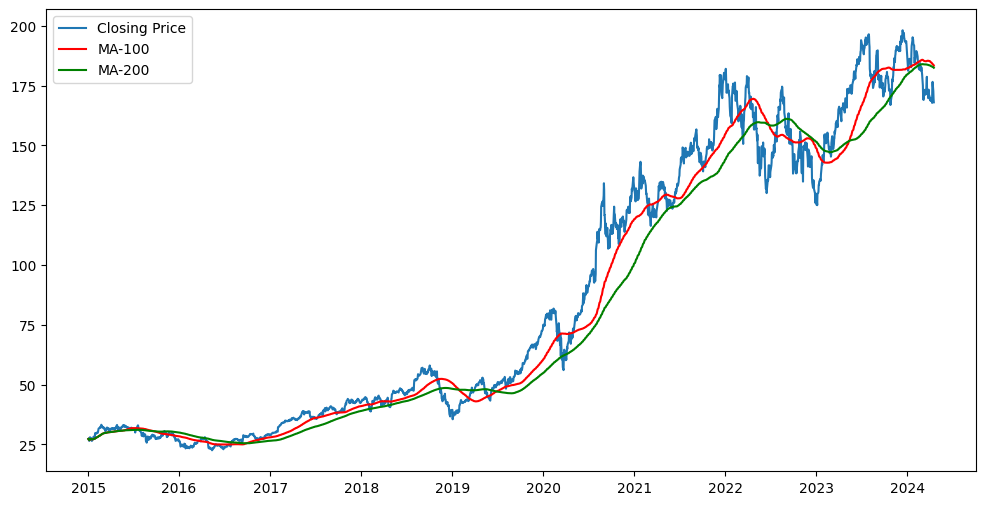

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'],label="Closing Price")
plt.plot(ma100,'r',label="MA-100")
plt.plot(ma200,'g',label="MA-200")
plt.legend()

In [ ]:
fig = px.line(y='Close',data_frame=df2)
fig.add_scatter(y=ma100,name='100 Day Moving Avg')
fig.add_scatter(y=ma200,name='200 Day Moving Avg')
fig.update_layout()
fig.show()

In [ ]:
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
#                vertical_spacing=0.10, subplot_titles=('CBA', 'Volume'),
#                row_width=[0.2, 0.7])
fig2 = go.Figure(
    data=[
        go.Candlestick(
        x = df.index,
        open = df["Open"],
        high = df["High"],
        low = df["Low"],
        close = df["Close"]
        )
    ]
)
fig2.update(layout_xaxis_rangeslider_visible=False)
fig2.show()

In [ ]:
fig3 = go.Figure(
    data = [
        go.Bar(
            x=df.index,
            y=df['Volume'],
            marker_color='blue',
            showlegend=False,
        )])
fig3.show()

In [ ]:
df.shape

(2338, 5)

In [ ]:
X_train = pd.DataFrame(df['Close'][0 : int(len(df)*0.70)])
X_test = pd.DataFrame(df['Close'][int(len(df)*0.70) : int(len(df))])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1636, 1)
(702, 1)


In [ ]:
X_train.head()   #Training data in order because time series

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_training_array = scaler.fit_transform(X_train)
data_training_array

array([[0.03937384],
       [0.03298777],
       [0.03300851],
       ...,
       [0.94335475],
       [0.94857975],
       [0.95115074]])

In [ ]:
data_training_array.shape

(1636, 1)

In [ ]:
x_train = []
y_train = []

for i in range(100 , data_training_array.shape[0]):
    x_train.append(data_training_array[i-100 : i])  #From 0 to 100
    y_train.append(data_training_array[i,0])        #Only one column

x_train , y_train = np.array(x_train) , np.array(y_train)

In [ ]:
x_train.shape

(1536, 100, 1)

In [ ]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 29249 (114.25 KB)
Trainable params: 29249 (114.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
48/48 [==============================] - 8s 87ms/step - loss: 0.0335
Epoch 2/50
48/48 [==============================] - 3s 71ms/step - loss: 0.0106
Epoch 3/50
48/48 [==============================] - 3s 66ms/step - loss: 0.0063
Epoch 4/50
48/48 [==============================] - 3s 66ms/step - loss: 0.0052
Epoch 5/50
48/48 [==============================] - 4s 92ms/step - loss: 0.0056
Epoch 6/50
48/48 [==============================] - 3s 66ms/step - loss: 0.0054
Epoch 7/50
48/48 [==============================] - 3s 64ms/step - loss: 0.0046
Epoch 8/50
48/48 [==============================] - 3s 65ms/step - loss: 0.0052
Epoch 9/50
48/48 [==============================] - 4s 91ms/step - loss: 0.0048
Epoch 10/50
48/48 [==============================] - 3s 66ms/step - loss: 0.0046
Epoch 11/50
48/48 [==============================] - 3s 65ms/step - loss: 0.0050
Epoch 12/50
48/48 [==============================] - 3s 72ms/step - loss: 0.0044
Epoch 13/50
48/48 [==================

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('final_model.keras')

ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0']

In [ ]:
X_test.head()   # For predition we need previous 100 data rows thus we need to append

,Close
Date,
2021-07-02,139.960007
2021-07-06,142.020004
2021-07-07,144.570007
2021-07-08,143.240005
2021-07-09,145.110001


In [ ]:
X_train.tail(100)

,Close
Date,
2021-02-09,136.009995
2021-02-10,135.389999
2021-02-11,135.130005
2021-02-12,135.369995
2021-02-16,133.190002
...,...
2021-06-25,133.110001
2021-06-28,134.779999
2021-06-29,136.330002


In [ ]:
past_100_days = X_train.tail(100)

In [ ]:
final_df = pd.concat([past_100_days,X_test],ignore_index=True)

In [ ]:
final_df.head()

,Close
0,136.009995
1,135.389999
2,135.130005
3,135.369995
4,133.190002


In [ ]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.2403669 ],
       [0.23278286],
       [0.2296025 ],
       [0.23253816],
       [0.20587158],
       [0.17712533],
       [0.16330283],
       [0.16525987],
       [0.11792048],
       [0.11620795],
       [0.10996939],
       [0.05663605],
       [0.05993886],
       [0.13981652],
       [0.10715599],
       [0.06972473],
       [0.04611617],
       [0.06189599],
       [0.        ],
       [0.05785927],
       [0.04428138],
       [0.06850151],
       [0.05712536],
       [0.0933333 ],
       [0.11266054],
       [0.10275231],
       [0.05100915],
       [0.04440364],
       [0.08599387],
       [0.07559633],
       [0.04562686],
       [0.05174307],
       [0.0593272 ],
       [0.06152904],
       [0.04330276],
       [0.0708257 ],
       [0.08122323],
       [0.11669726],
       [0.12048928],
       [0.14116209],
       [0.17125382],
       [0.20354739],
       [0.18201841],
       [0.22103966],
       [0.19168193],
       [0.22189602],
       [0.21773704],
       [0.226

In [ ]:
input_data.shape

(802, 1)

In [ ]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100 : i])
    y_test.append(input_data[i , 0])

In [ ]:
x_test , y_test = np.array(x_test) , np.array(y_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(702, 100, 1)
(702,)


In [ ]:
predicted = model.predict(x_test)

22/22 [==============================] - 1s 26ms/step


In [ ]:
predicted.shape

(702, 1)

In [ ]:
scaler.scale_

array([0.01223242])

In [ ]:
scale_factor = 1/(scaler.scale_[0])

In [ ]:
predicted = predicted*scale_factor
y_test = y_test*scale_factor

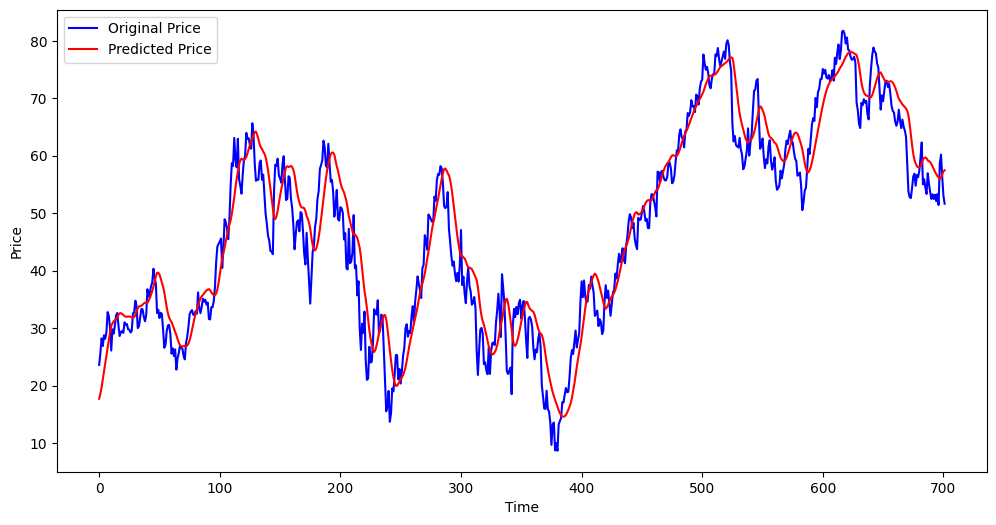

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label="Original Price")
plt.plot(predicted,'r',label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
import numpy as np

def calculate_accuracy(y_test, predicted):
    mae = np.mean(np.abs(y_test - predicted))
    rmse = np.sqrt(np.mean((y_test - predicted)**2))
    mape = (mae / y_test.mean()) * 100
    return mae, rmse, mape

mae, rmse, mape = calculate_accuracy(y_test, predicted)

print("MAE: ", round(mae,3))
print("RMSE:", round(rmse,3))
print("MAPE:", round(mape,3),'%')

MAE:  19.733
RMSE: 24.255
MAPE: 41.95 %


In [ ]:
df2 = df2[["Date", "Close"]]
df2.head()

,Date,Close
0,2015-01-02,27.332500
1,2015-01-05,26.562500
2,2015-01-06,26.565001
3,2015-01-07,26.937500
4,2015-01-08,27.972500


In [ ]:
df2.columns = ['ds','y']
df2.tail()

,ds,y
2333,2024-04-11,175.039993
2334,2024-04-12,176.550003
2335,2024-04-15,172.690002
2336,2024-04-16,169.380005
2337,2024-04-17,168.000000


In [ ]:
model = fb.Prophet(daily_seasonality=True)
model.fit(df2)
future_dates = model.make_future_dataframe(periods=15)
predictions = model.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjskkrh1q/ucznp5hp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjskkrh1q/07waaq_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70747', 'data', 'file=/tmp/tmpjskkrh1q/ucznp5hp.json', 'init=/tmp/tmpjskkrh1q/07waaq_j.json', 'output', 'file=/tmp/tmpjskkrh1q/prophet_modeliy73gekj/prophet_model-20240418101242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
predictions.iloc[-15:]["yhat"].to_numpy()

array([188.67907214, 188.75893025, 188.21958302, 188.36822751,
       189.34106602, 189.42032358, 189.56999086, 189.6461955 ,
       189.66032127, 189.04969503, 189.12231903, 190.01535888,
       190.01214171, 190.07787566, 190.06999429])

In [ ]:
from prophet.plot import plot_plotly
plot_plotly(model,predictions)